In [89]:
import numpy as np
import time
import random
from math import sqrt,fabs,log
import sys
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED
import matplotlib.pyplot as plt

In [90]:
unum = 4010
inum = 9788

In [111]:
pred_rating=np.loadtxt('dim128-30-30neg8.txt')

In [112]:
np.shape(pred_rating)

(4010, 9788)

In [113]:
pred_rating

array([[0.01804564, 0.09269208, 0.02877624, ..., 0.0931388 , 0.02033034,
        0.02335667],
       [0.01724754, 0.12130129, 0.0459203 , ..., 0.16342562, 0.02230319,
        0.02903609],
       [0.00953697, 0.02063296, 0.03477343, ..., 0.08769853, 0.02013675,
        0.0178079 ],
       ...,
       [0.0174389 , 0.05140446, 0.02901876, ..., 0.06090273, 0.01347486,
        0.01860818],
       [0.01850526, 0.03234754, 0.0788016 , ..., 0.2429299 , 0.01802229,
        0.02070439],
       [0.01063247, 0.02544141, 0.01332381, ..., 0.04856848, 0.01320182,
        0.0091848 ]])

In [114]:
import pandas as pd
data = []
with open('../data/um_0.8.test', 'r') as infile:
    for line in infile.readlines():
        user, item, rating = line.strip().split('\t')
        
        data.append([int(user), int(item), rating])
        
test = pd.DataFrame(data=data, columns=["userID", "itemID", "rating"])

In [115]:
R_t=np.zeros([unum,inum])
with open('../data/um_0.8.train', 'r') as infile:
    for line in infile.readlines():
        user, item, rating = line.strip().split('\t')
        R_t[int(user)-1,int(item)-1]=1

In [116]:
data = []
for u in tqdm(range(unum)):
    pred_rating_user_item = np.argsort(pred_rating[u,:])[::-1][:]
    n=0
    i=0
    while n<20:
        if R_t[u,int(pred_rating_user_item[i])]==0:
            data.append([int(u)+1,int(pred_rating_user_item[i])+1,pred_rating[u,pred_rating_user_item[i]]])
            n+=1
            i+=1
        else:
            i+=1
all_predictions = pd.DataFrame(data=data, columns=["userID", "itemID", "prediction"])
all_predictions

100%|█████████████████████████████████████| 4010/4010 [00:01<00:00, 2430.82it/s]


,userID,itemID,prediction
0,1,9021,0.835784
1,1,8170,0.830182
2,1,7229,0.813554
3,1,8841,0.803458
4,1,9578,0.793706
...,...,...,...
80195,4010,7810,0.803929
80196,4010,6270,0.798286
80197,4010,8863,0.794053
80198,4010,3836,0.791115


In [117]:
k = 10
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print("Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Precision@K:	0.148260
Recall@K:	0.119300


In [118]:
k = 20
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print("Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Precision@K:	0.123792
Recall@K:	0.181921


In [119]:
count=np.zeros([inum,2])
with open("../data/um.dat") as infile:
            for line in infile.readlines():
                user, item, rating = line.strip().split('\t')
                count[int(item)-1][0]+=1

for i in range(inum):
    count[i][1]=i
scount=sorted(count,reverse=True,key=lambda x:x[0])
ref=np.zeros([inum+1])
cnt = 1
for f,i in scount:
    ref[int(i)+1]=cnt
    cnt+=1

<BarContainer object of 9788 artists>

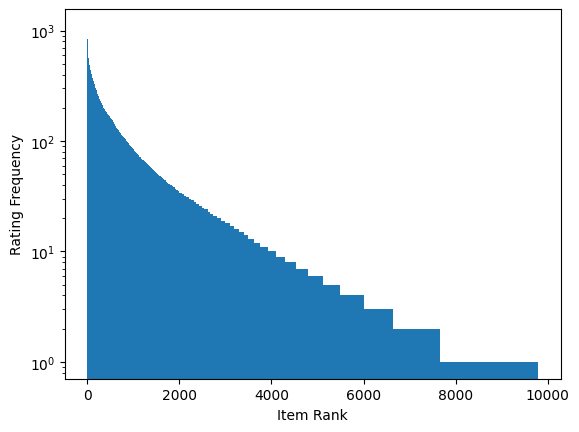

In [120]:
x=range(inum)
y=[]
for i in range(inum):
    y.append(scount[i][0])
plt.xlabel("Item Rank")
plt.ylabel("Rating Frequency")
plt.bar(x,y,width=1.0,log=True)

In [163]:
user_id = 800
print("User_id : ",user_id)
n=0
i=0
hits = 0
purchase_list_user = test[test.userID == user_id].loc[:, 'itemID'].unique()
print('Purchase list:\n', purchase_list_user)
print(len(purchase_list_user))
pred_rating_user_item = np.argsort(pred_rating[user_id-1,:])[::-1][:]
while n<20:
    if R_t[int(user_id)-1,int(pred_rating_user_item[i])]==0:
        if int(pred_rating_user_item[i])+1 in purchase_list_user:
            print("&",n+1,"\t&",int(pred_rating_user_item[i])+1,"\t&",int(ref[int(pred_rating_user_item[i])+1]),"\t&",'{:.4g}'.format(pred_rating[user_id-1,pred_rating_user_item[i]]),"\t&",'1'," \\\\")
            hits += 1
        else :
            print("&",n+1,"\t&",int(pred_rating_user_item[i])+1,"\t&",int(ref[int(pred_rating_user_item[i])+1]),"\t&",'{:.4g}'.format(pred_rating[user_id-1,pred_rating_user_item[i]]),"\t&",'0'," \\\\")
        n+=1
        i+=1
    else:
        i+=1
if(len(purchase_list_user)!=0):
    print('Precision@20:\t', hits / 20.0)
    print('Recall@20:\t', hits / len(purchase_list_user))

User_id :  800
Purchase list:
 [2454 2934 3008  728 5020 3433 2048 2335 3272 4814 3366 6759 3809 4463
 5645 3563 2034 5845 1971 2619 7871 8251 1282 1290 7829  332 3719 6474
 4140 3013  536 9491  467 6123 4768 5419 5862 3261 6804 3824 7632  466
 8185 1285 5559  297 4195 5350 1695 3032  328 2212 5336 3223 4769 5887
 5960 2741  341 4093 4511 4706 4421 2392  347 7503 4950 4529 7572 5402
 8072 3194 4765 2121 5692 5690  912 1883 4921 4275 1918  406 8186 4913
 6106 7367 3442  550 6380 5765 6780  447 4121 1418 2621  310 1256 5787
 5665 3518  565 6997 4319 3491 8129 7926 7758 3238 3660 6276  363 7785
 2091 2397 5691]
115
& 1 	& 550 	& 185 	& 0.8015 	& 1  \\
& 2 	& 6380 	& 178 	& 0.7822 	& 1  \\
& 3 	& 3272 	& 417 	& 0.7722 	& 1  \\
& 4 	& 1722 	& 1105 	& 0.738 	& 0  \\
& 5 	& 4511 	& 440 	& 0.7156 	& 1  \\
& 6 	& 4121 	& 189 	& 0.7132 	& 1  \\
& 7 	& 7758 	& 277 	& 0.7088 	& 1  \\
& 8 	& 2678 	& 286 	& 0.7047 	& 0  \\
& 9 	& 961 	& 1500 	& 0.685 	& 0  \\
& 10 	& 856 	& 541 	& 0.663 	& 0  \\
& 1

###### 

In [156]:
pre20=[]
rec20=[]
cnt=np.zeros(inum+1)
for u in range(unum):
    user_id = u+1
    #print("User_id : ",user_id)
    n=0
    i=0
    hits = 0
    purchase_list_user = test[test.userID == user_id].loc[:, 'itemID'].unique()
    #print('Purchase list:\n', purchase_list_user)
    pred_rating_user_item = np.argsort(pred_rating[user_id-1,:])[::-1][:]
    while n<20:
        if R_t[int(user_id)-1,int(pred_rating_user_item[i])]==0:
            if int(pred_rating_user_item[i])+1 in purchase_list_user:
                #print("Recommend ",n+1,":\t",int(pred_rating_user_item[i])+1,"\tRank:",int(ref[int(pred_rating_user_item[i])+1]),"\tScore:",pred_rating[user_id-1,pred_rating_user_item[i]],"\to")
                hits += 1
            #else :
                #print("Recommend ",n+1,":\t",int(pred_rating_user_item[i])+1,"\tRank:",int(ref[int(pred_rating_user_item[i])+1]),"\tScore:",pred_rating[user_id-1,pred_rating_user_item[i]])
            cnt[int(ref[int(pred_rating_user_item[i])+1])]+=1
            n+=1
            i+=1
        else:
            i+=1
    #print('Precision@20:', hits / 20.0)
    if(len(purchase_list_user)!=0):
        pre20.append(hits/20.0)
        rec20.append(hits/len(purchase_list_user))
print('Precision@20:\t',sum(pre20)/len(pre20))
print('Recall@20:\t',sum(rec20)/len(rec20))

Precision@20:	 0.12379182156133962
Recall@20:	 0.181921153089827


<BarContainer object of 9789 artists>

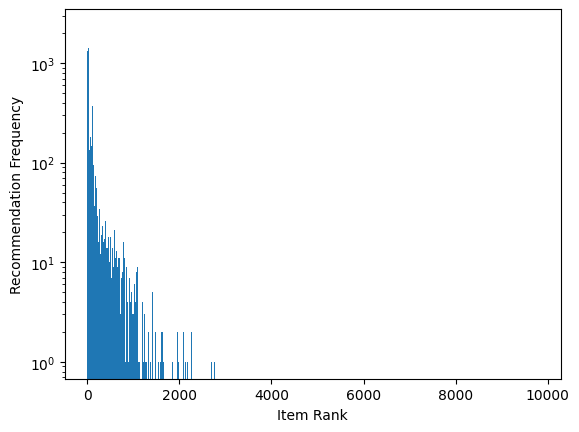

In [123]:
plt.xlabel("Item Rank")
plt.ylabel("Recommendation Frequency")
plt.bar(range(inum+1),cnt, width=1.0,log=True)

(array([1539.,  606.,  359.,  217.,   74.,  112.,   37.,    9.,    4.,
           2.]),
 array([0.  , 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9 ]),
 <BarContainer object of 10 artists>)

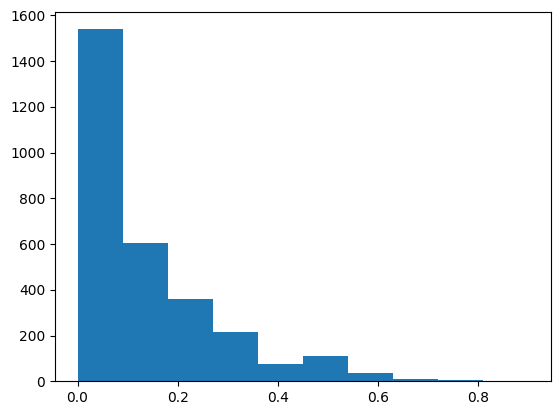

In [124]:
plt.hist(pre20)

(array([1471.,  573.,  355.,  147.,   67.,  142.,   21.,   19.,    3.,
         161.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

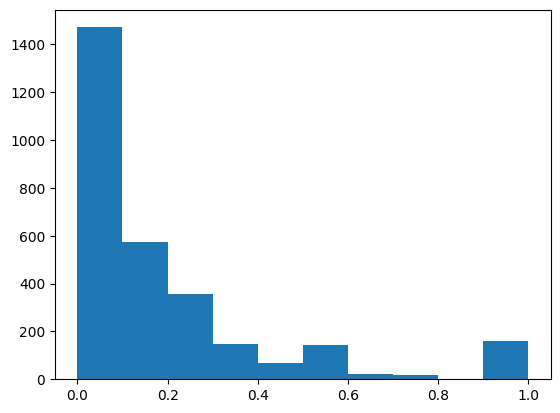

In [125]:
plt.hist(rec20)

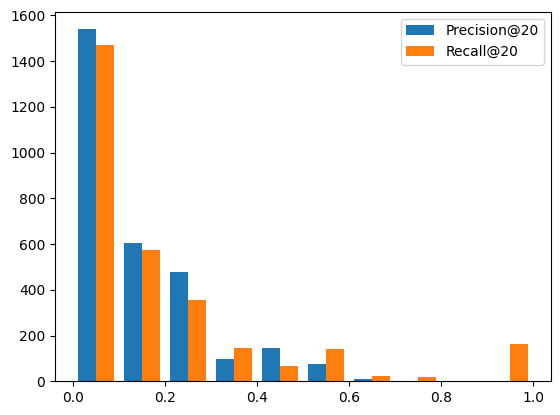

In [126]:
labels = ['Precision@20', 'Recall@20']
plt.hist([pre20, rec20], label=labels)
plt.legend()

In [127]:
pre10=[]
rec10=[]
for u in range(unum):
    user_id = u+1
    #print("User_id : ",user_id)
    n=0
    i=0
    hits = 0
    purchase_list_user = test[test.userID == user_id].loc[:, 'itemID'].unique()
    #print('Purchase list:\n', purchase_list_user)
    pred_rating_user_item = np.argsort(pred_rating[user_id-1,:])[::-1][:]
    while n<10:
        if R_t[int(user_id)-1,int(pred_rating_user_item[i])]==0:
            if int(pred_rating_user_item[i])+1 in purchase_list_user:
                #print("Recommend ",n+1,":\t",int(pred_rating_user_item[i])+1,"\tRank:",int(ref[int(pred_rating_user_item[i])+1]),"\tScore:",pred_rating[user_id-1,pred_rating_user_item[i]],"\to")
                hits += 1
            #else :
                #print("Recommend ",n+1,":\t",int(pred_rating_user_item[i])+1,"\tRank:",int(ref[int(pred_rating_user_item[i])+1]),"\tScore:",pred_rating[user_id-1,pred_rating_user_item[i]])
            n+=1
            i+=1
        else:
            i+=1
    #print('Precision@20:', hits / 20.0)
    if(len(purchase_list_user)!=0):
        pre10.append(hits/10.0)
        rec10.append(hits/len(purchase_list_user))
print('Precision@10:\t',sum(pre10)/len(pre10))
print('Recall@10:\t',sum(rec10)/len(rec10))

Precision@10:	 0.14825954714430592
Recall@10:	 0.11929962850066346


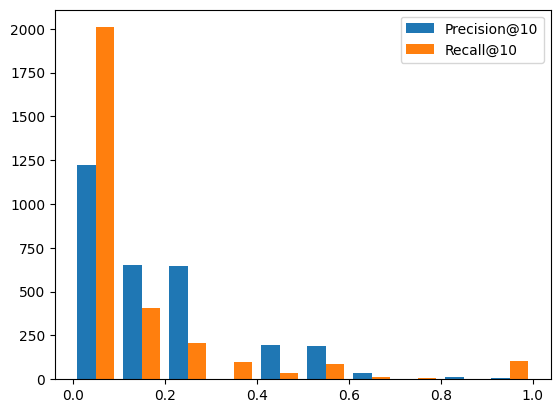

In [128]:
labels = ['Precision@10', 'Recall@10']
plt.hist([pre10, rec10], label=labels)
plt.legend()

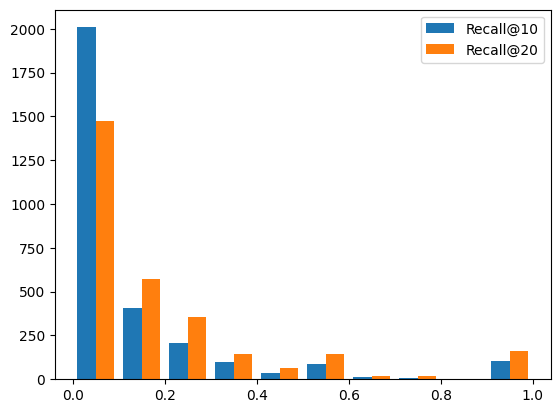

In [129]:
labels = ['Recall@10', 'Recall@20']
plt.hist([rec10, rec20], label=labels)
plt.legend()

In [130]:
MFKG10=rec10
MFKG20=rec20

In [110]:
MF202010=rec10
MF202020=rec20

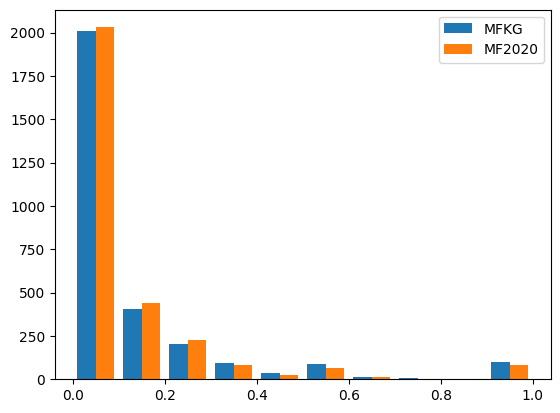

In [133]:
labels = ['MFKG', 'MF2020']
plt.hist([MFKG10, MF202010], label=labels)
plt.legend()

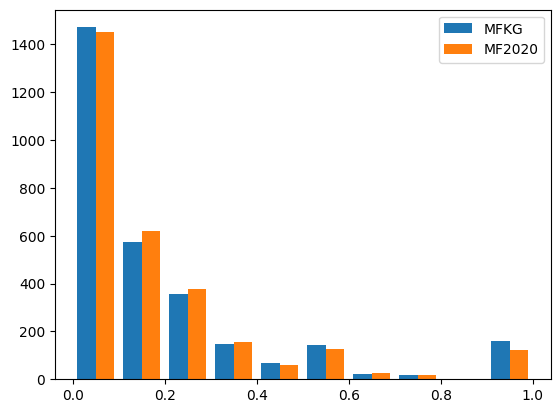

In [132]:
labels = ['MFKG', 'MF2020']
plt.hist([MFKG20, MF202020], label=labels)
plt.legend()